In [5]:
from datetime import date 
import tempfile
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import pandas as pd
import math
from astropy.io import fits
from astropy.time import Time
from astropy import wcs
temp_dir = tempfile.TemporaryDirectory()
import math
import os
import random
import time
from math import pi
from random import choices
from time import gmtime, strftime
from typing import Optional
import astropy.constants as C
import astropy.units as U
import h5py
import nifty8 as ift
from astropy.constants import c
import astropy.cosmology.units as cu
from astropy.cosmology import Planck13
from astropy.time import Time
from astropy.wcs import WCS
import pyvo
from scipy.optimize import curve_fit

In [6]:
def query_observations(service, member_ous_uid, target_name):
    """Query for all science observations of given member OUS UID and target name, selecting all columns of interest.

    Parameters:
    service (pyvo.dal.TAPService): A TAPService instance for querying the database.
    member_ous_uid (str): The unique identifier for the member OUS to filter observations by.
    target_name (str): The target name to filter observations by.

    Returns:
    pandas.DataFrame: A table of query results.
    """

    query = f"""
            SELECT *
            FROM ivoa.obscore
            WHERE member_ous_uid = '{member_ous_uid}'
            AND target_name = '{target_name}'
            AND is_mosaic = 'F'
            """

    result = service.search(query).to_table().to_pandas()

    return result

In [7]:
def get_science_types(service):
    query = f"""  
            SELECT science_keyword, scientific_category  
            FROM ivoa.obscore  
            WHERE science_observation = 'T'    
            """
    db = service.search(query).to_table().to_pandas()
    science_keywords = db['science_keyword'].unique()
    scientific_category = db['scientific_category'].unique()
    science_keywords = list(filter(lambda x: x != "", science_keywords))
    scientific_category = list(filter(lambda x: x != "", scientific_category))
    return  science_keywords, scientific_category

In [15]:
def get_science_types(service):
    query = f"""  
            SELECT science_keyword, scientific_category  
            FROM ivoa.obscore  
            WHERE science_observation = 'T'    
            """
    db = service.search(query).to_table().to_pandas()
    science_keywords = db['science_keyword'].unique()
    scientific_category = db['scientific_category'].unique()
    science_keywords = list(filter(lambda x: x != "", science_keywords))
    scientific_category = list(filter(lambda x: x != "", scientific_category))

    unique_keywords = []

    # Iterazione attraverso ogni stringa nella lista
    for keywords_string in science_keywords:
    # Dividi la stringa in base alla virgola e rimuovi gli spazi bianchi
        keywords_list = [keyword.strip() for keyword in keywords_string.split(',')]
    # Aggiungi le parole alla lista dei valori univoci
        unique_keywords.extend(keywords_list)

    # Utilizza il set per ottenere i valori univoci
    unique_keywords = list(set(unique_keywords))

    return  unique_keywords, scientific_category

In [8]:
def query_all_targets(service, targets):
    """Query observations for all predefined targets and compile the results into a single DataFrame.

    Parameters:
    service (pyvo.dal.TAPService): A TAPService instance for querying the database.
    targets (list of tuples): A list where each tuple contains (target_name, member_ous_uid).

    Returns:
    pandas.DataFrame: A DataFrame containing the results for all queried targets.
    """
    results = []

    for target_name, member_ous_uid in targets:
        result = query_observations(service, member_ous_uid, target_name)
        results.append(result)

    # Concatenate all DataFrames into a single DataFrame
    df = pd.concat(results, ignore_index=True)

    return df

In [9]:
def query_for_metadata_by_targets(targets, path, service_url: str = "https://almascience.eso.org/tap"):
    """Query for metadata for all predefined targets and compile the results into a single DataFrame.

    Parameters:
    service_url (str): A TAPService http address for querying the database.
    targets (list of tuples): A list where each tuple contains (target_name, member_ous_uid).
    path (str): The path to save the results to.

    Returns:
    pandas.DataFrame: A DataFrame containing the results for all queried targets.
    """
    # Create a TAPService instance (replace 'your_service_url' with the actual URL)
    service = pyvo.dal.TAPService(service_url)
    # Query all targets and compile the results
    df = query_all_targets(service, targets)
    df = df.drop_duplicates(subset='member_ous_uid')
    # Define a dictionary to map existing column names to new names with unit initials
    rename_columns = {
    'target_name': 'ALMA_source_name',
    'pwv': 'PWV',
    'schedblock_name': 'SB_name',
    'velocity_resolution': 'Vel.res.',
    'spatial_resolution': 'Ang.res.',
    's_ra': 'RA',
    's_dec': 'Dec',
    's_resolution': 'Spatial.resolution',
    's_fov': 'FOV',
    't_resolution': 'Int.Time',
    't_max': 'Total.Time',
    'cont_sensitivity_bandwidth': 'Cont_sens_mJybeam',
    'sensitivity_10kms': 'Line_sens_10kms_mJybeam',
    'obs_release_date': 'Obs.date',
    'band_list': 'Band',
    'bandwidth': 'Bandwidth',
    'frequency': 'Freq',
    'frequency_support': 'Freq.support',

    }
    # Rename the columns in the DataFrame
    df.rename(columns=rename_columns, inplace=True)
    database = df[['ALMA_source_name', 'Band', 'PWV', 'SB_name', 'Vel.res', 'Ang.res', 'RA', 'Dec', 'FOV', 'Int.Time', 
                    'Total.Time', 'Cont_sens_mJybeam', 'Line_sens_10kms_mJybeam', 'Obs.date', 'Bandwidth', 'Freq', 
                    'Freq.support', 'Spatial.resolution']]
    database = database[database['Obs.date'] <= '2024-9-30']
    database['Obs.date'] = database['Obs.date'].apply(lambda x: x.split('T')[0])
    database.to_csv(path, index=False)
    return database

In [10]:
def query_by_science_type(service, science_keyword=None, scientific_category=None):
    """Query for all science observations of given member OUS UID and target name, selecting all columns of interest.

    Parameters:
    service (pyvo.dal.TAPService): A TAPService instance for querying the database.

    Returns:
    pandas.DataFrame: A table of query results.
    """
    if science_keyword == None:
        science_keyword = ""
    if scientific_category == None:
        scientific_category = ""
    print('Querying for science keyword/s: ', science_keyword)
    print('And scientific category/ies: ', scientific_category)
    if type(science_keyword) == list and len(science_keyword) == 1:
        science_keyword = science_keyword[0]
        science_keyword_query = f"science_keyword like '%{science_keyword}%'"
    elif type(science_keyword) == list and len(science_keyword) > 1:
        science_keyword = "', '".join(science_keyword)
        science_keyword_query = f"science_keyword in ('{science_keyword}')"
    else:
        science_keyword_query = f"science_keyword like '%{science_keyword}%'"
    if type(scientific_category) == list and len(scientific_category) == 1:
        scientific_category = scientific_category[0]
        scientific_category_query = f"scientific_category like '%{scientific_category}%'"
    elif type(scientific_category) == list and len(scientific_category) > 1:
        scientific_category = "', '".join(scientific_category)
        scientific_category_query = f"scientific_category in ('{scientific_category}')"
    else:
        scientific_category_query = f"scientific_category like '%{scientific_category}%'"


    query = f"""
            SELECT *
            FROM ivoa.obscore
            WHERE {science_keyword_query}
            AND {scientific_category_query}
            AND is_mosaic = 'F'
            """

    result = service.search(query).to_table().to_pandas()

    return result


In [16]:
def query_for_metadata_by_science_type(path, service_url: str = "https://almascience.eso.org/tap"):
    service = pyvo.dal.TAPService(service_url)
    science_keywords, scientific_categories = get_science_types(service)
    print('Available science keywords:')
    for i in range(len(science_keywords)):
        print(f'{i}: {science_keywords[i]}')
    print('Available scientific categories:')
    for i in range(len(scientific_categories)):
        print(f'{i}: {scientific_categories[i]}')
    science_keyword_number = input('Plese select the Science Keyword by number, if you want to select multiple numbers separate them by a space, leave empty for all:' )
    scientific_category_number = input('Plese select the Scientific Category by number, if you want to select multiple numbers separate them by a space, leave empty for all:' )
    if science_keyword_number == "":
        science_keyword = None
    else:
        science_keyword_number = [int(x) for x in science_keyword_number.split(' ')]
        science_keyword = [science_keywords[i] for i in science_keyword_number]
    if scientific_category_number == "":
        scientific_category = None
    else:
        scientific_category_number = [int(x) for x in scientific_category_number.split(' ')]
        scientific_category = [scientific_categories[i] for i in scientific_category_number]
    df = query_by_science_type(service, science_keyword, scientific_category)
    df = df.drop_duplicates(subset='member_ous_uid')
    
    # Define a dictionary to map existing column names to new names with unit initials
    rename_columns = {
    'target_name': 'ALMA_source_name',
    'pwv': 'PWV',
    'schedblock_name': 'SB_name',
    'velocity_resolution': 'Vel.res.',
    'spatial_resolution': 'Ang.res.',
    's_ra': 'RA',
    's_dec': 'Dec',
    's_fov': 'FOV',
    't_resolution': 'Int.Time',
    't_max': 'Total.Time',
    'cont_sensitivity_bandwidth': 'Cont_sens_mJybeam',
    'sensitivity_10kms': 'Line_sens_10kms_mJybeam',
    'obs_release_date': 'Obs.date',
    'band_list': 'Band',
    'bandwidth': 'Bandwidth',
    'frequency': 'Freq',
    'frequency_support': 'Freq.sup.'

    }
    # Rename the columns in the DataFrame
    df.rename(columns=rename_columns, inplace=True)
    database = df[['ALMA_source_name', 'Band', 'PWV', 'SB_name', 'Vel.res.', 'Ang.res.', 'RA', 'Dec', 'FOV', 'Int.Time', 
                    'Total.Time', 'Cont_sens_mJybeam', 'Line_sens_10kms_mJybeam', 'Obs.date', 'Bandwidth', 'Freq', 
                    'Freq.sup.', 'antenna_arrays']]
    database['Obs.date'] = database['Obs.date'].apply(lambda x: x.split('T')[0])
    database.to_csv(path, index=False)
    return database


In [17]:
parent_dir = os.path.dirname(os.getcwd())
metadata = query_for_metadata_by_science_type(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))

Available science keywords:
0: feedback
1: Early-type galaxies
2: Asymptotic Giant Branch (AGB) stars
3: Solar system - Trans-Neptunian Objects (TNOs)
4: Evolved stars: Shaping/physical structure
5: Supernovae (SN) ejecta
6: Surveys of galaxies
7: Low-mass star formation
8: Magellanic Clouds
9: Cosmic Microwave Background (CMB)/Sunyaev-Zel'dovich Effect (SZE)
10: Solar system - Asteroids
11: Lyman Alpha Emitters/Blobs (LAE/LAB)
12: Galaxy groups and clusters
13: Gamma Ray Bursts (GRB)
14: Infra-Red Dark Clouds (IRDC)
15: jets and ionized winds
16: Black holes
17: Transients
18: jets
19: Debris disks
20: Luminous and Ultra-Luminous Infra-Red Galaxies (LIRG & ULIRG)
21: Inter-Stellar Medium (ISM)/Molecular clouds
22: Solar system - Planetary surfaces
23: Outflows
24: High-z Active Galactic Nuclei (AGN)
25: Sub-mm Galaxies (SMG)
26: Galactic centres/nuclei
27: Exoplanets
28: Photon-Dominated Regions (PDR)/X-Ray Dominated Regions (XDR)
29: Galaxy structure &evolution
30: Disks around low-m

In [13]:
metadata.info

<bound method DataFrame.info of Empty DataFrame
Columns: [ALMA_source_name, Band, PWV, SB_name, Vel.res., Ang.res., RA, Dec, FOV, Int.Time, Total.Time, Cont_sens_mJybeam, Line_sens_10kms_mJybeam, Obs.date, Bandwidth, Freq, Freq.sup., antenna_arrays]
Index: []>

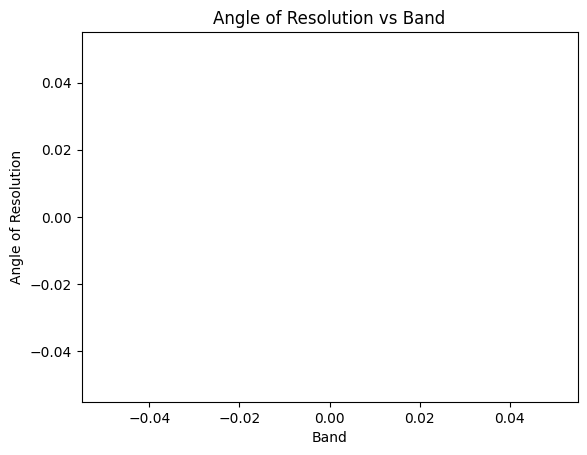

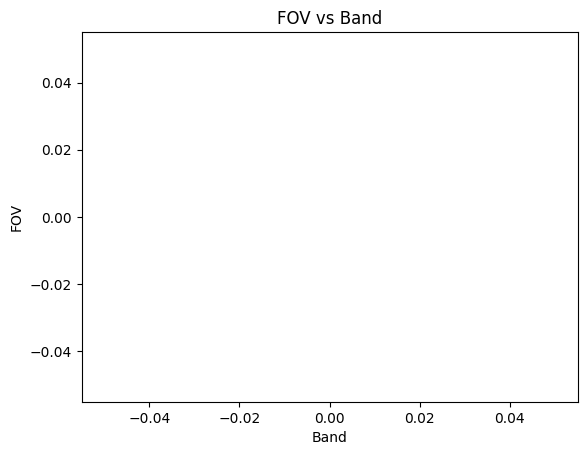

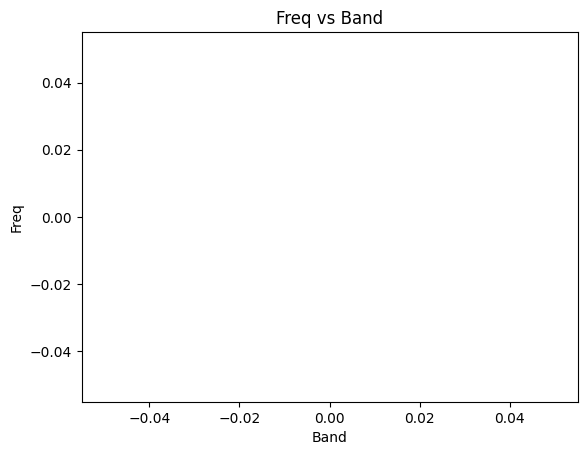

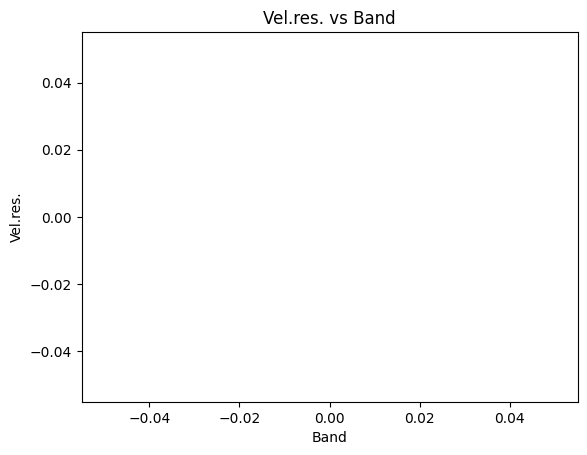

Index(['ALMA_source_name', 'Band', 'PWV', 'SB_name', 'Vel.res.', 'Ang.res.',
       'RA', 'Dec', 'FOV', 'Int.Time', 'Total.Time', 'Cont_sens_mJybeam',
       'Line_sens_10kms_mJybeam', 'Obs.date', 'Bandwidth', 'Freq', 'Freq.sup.',
       'antenna_arrays'],
      dtype='object')

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv(os.path.join(parent_dir, 'metadata', 'Active_galaxies_metadata.csv'))
plt.scatter(df['Band'], df['Ang.res.'])
plt.xlabel('Band')
plt.ylabel('Angle of Resolution')
plt.title('Angle of Resolution vs Band')
plt.show()
plt.scatter(df['Band'],df['FOV'])
plt.xlabel('Band')
plt.ylabel('FOV')
plt.title('FOV vs Band')
plt.show()
plt.scatter(df['Band'],df['Freq'])
plt.xlabel('Band')
plt.ylabel('Freq')
plt.title('Freq vs Band')
plt.show()
plt.scatter(df['Band'],df['Vel.res.'])
plt.xlabel('Band')
plt.ylabel('Vel.res.')
plt.title('Vel.res. vs Band')
plt.show()
df.columns